In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [28]:
# Check the columns for each table
inspector = inspect(engine)

m_col = inspector.get_columns(Base.classes.keys()[0])
print("Columns in Measurement Table:")
for column in m_col:
    print(column["name"], column["type"])

print(" ")

s_col = inspector.get_columns(Base.classes.keys()[1])
print("Columns in Stations Table:")
for column in s_col:
    print(column["name"], column["type"])

Columns in Measurement Table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
Columns in Stations Table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


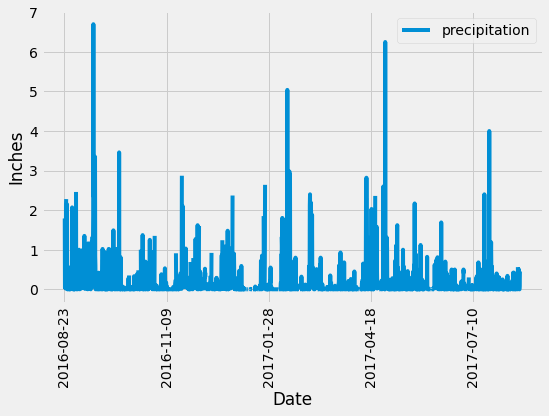

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).first()[0]

x = last_date.split("-")
for i in range(0, len(x)):
    x[i] = int(x[i])

year_ago_date = (dt.date(x[0], x[1], x[2]) - dt.timedelta(days = 365))
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns = ["date", "precipitation"])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by = ["date"])


# Use Pandas Plotting with Matplotlib to plot the data
# check how to change xticks intervals
prcp_df.plot("date", "precipitation", figsize=(8,5))
plt.xticks(rotation = "vertical")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
print(f"There are {station_count} stations in this dataset")

There are 9 stations in this dataset


In [57]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_tobs_counts = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
                        filter(Measurement.station == Station.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

most_active_station_id = station_tobs_counts[0][0]

In [92]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
record_analysis = session.query(func.min(Measurement.tobs),\
      func.max(Measurement.tobs),func.avg(Measurement.tobs))\
            .filter(Measurement.station == most_active_station_id).all()

print(f"Temperature record analysis of station {most_active_station_id}:")
print(f"The lowest temperature recorded: {round(record_analysis[0][0])}")
print(f"The highest temperature recorded: {round(record_analysis[0][1])}")
print(f"The average temperature: {round(record_analysis[0][2], 2)}")

Temperature record analysis of station USC00519281:
The lowest temperature recorded: 54
The highest temperature recorded: 85
The average temperature: 71.66


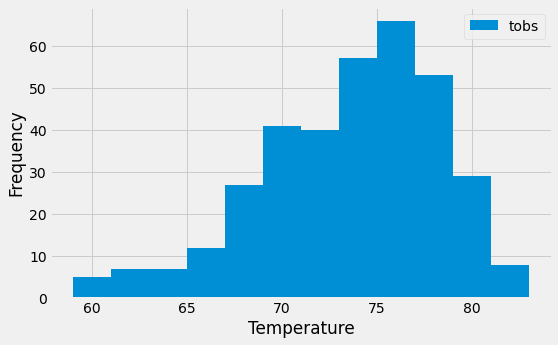

In [99]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_last_yr_data =  \
    session.query(Measurement.date,Measurement.tobs).\
        filter(Measurement.station == most_active_station_id).\
            filter(Measurement.date >= year_ago_date).all()

tobs_df = pd.DataFrame(most_active_station_last_yr_data)

tobs_df.plot(kind="hist", bins=12, figsize=(8,5))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()